In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Load data
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# Preview the first few rows
train.head()



,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [10]:
# Check for missing values

train.isna().sum().sort_values(ascending=False)


CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
Spa             183
FoodCourt       183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64

In [11]:
# Define the amenity spending columns
spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Create TotalSpent in both datasets
train['TotalSpent'] = train[spend_cols].sum(axis=1)
test['TotalSpent'] = test[spend_cols].sum(axis=1)


In [12]:
# Split PassengerId
train['GroupID'] = train['PassengerId'].str.split('_').str[0]
train['GroupSize'] = train.groupby('GroupID')['PassengerId'].transform('count')

# Split Cabin
train[['CabinDeck', 'CabinNum', 'CabinSide']] = train['Cabin'].str.split('/', expand=True)


In [13]:
spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
train['TotalSpent'] = train[spend_cols].sum(axis=1)


In [14]:
train.corr(numeric_only=True)['Transported'].sort_values(ascending=False)


Transported     1.000000
GroupSize       0.082644
FoodCourt       0.046566
ShoppingMall    0.010141
Age            -0.075026
TotalSpent     -0.199514
VRDeck         -0.207075
Spa            -0.221131
RoomService    -0.244611
Name: Transported, dtype: float64

In [15]:
train[['CabinDeck', 'CabinNum', 'CabinSide']] = train['Cabin'].str.split('/', expand=True)


<Axes: xlabel='Destination', ylabel='Transported'>

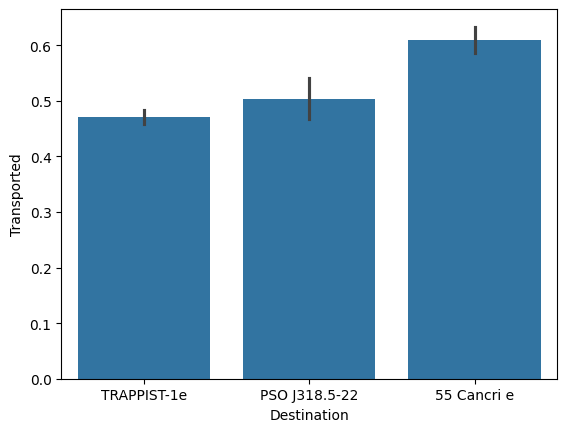

In [16]:
sns.barplot(data=train, x='Destination', y='Transported')


In [17]:
train.groupby(['CabinDeck', 'CryoSleep', 'Destination'])['Transported'].mean().unstack()


Destination          55 Cancri e  PSO J318.5-22  TRAPPIST-1e
CabinDeck CryoSleep                                         
A         False         0.351351       1.000000     0.304762
          True          0.937500       1.000000     0.939394
B         False         0.412698       0.500000     0.431373
          True          1.000000       1.000000     0.985849
C         False         0.407643       0.500000     0.488462
          True          1.000000       1.000000     0.985075
D         False         0.362319       0.352941     0.248148
          True          1.000000            NaN     0.983051
E         False         0.475610       0.645161     0.236462
          True          0.862069       0.777778     0.585938
F         False         0.315951       0.264574     0.303549
          True          0.983871       0.875000     0.987013
G         False         0.450000       0.368932     0.331375
          True          0.772727       0.677143     0.619772
T         False              NaN            NaN     0.250000

<Axes: title={'center': 'Age vs. Transported'}, xlabel='Age', ylabel='Count'>

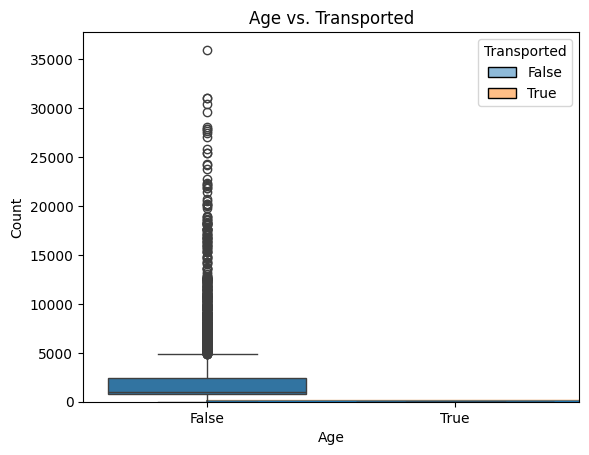

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Age distribution by Transported
sns.histplot(data=train, x='Age', hue='Transported', kde=True)
plt.title("Age vs. Transported")

# CryoSleep vs. Spending
sns.boxplot(data=train, x='CryoSleep', y='TotalSpent')


This tells us a lot, even though the correlations are small. `CryoSleep` has 217 missing
That’s a big one to resolve. Might correlate tightly with `TotalSpent == 0` and `CabinSide` being present.

In [19]:
# Impute or tag missing CryoSleep intelligently

# Let's see how many CryoSleep passengers have TotalSpent == 0
cryosleep_nulls = train[train['CryoSleep'].isna()]
print("Missing CryoSleep where TotalSpent is 0:", (cryosleep_nulls['TotalSpent'] == 0).sum())

# Compare that with CryoSleep=True vs False
print(train.groupby('CryoSleep')['TotalSpent'].describe())


Missing CryoSleep where TotalSpent is 0: 98
            count         mean          std  min    25%     50%     75%  \
CryoSleep                                                                 
False      5439.0  2248.299687  3245.061489  0.0  746.0  1019.0  2416.0   
True       3037.0     0.000000     0.000000  0.0    0.0     0.0     0.0   

               max  
CryoSleep           
False      35987.0  
True           0.0  


Text(0.5, 1.0, 'GroupSize Distribution by Transported')

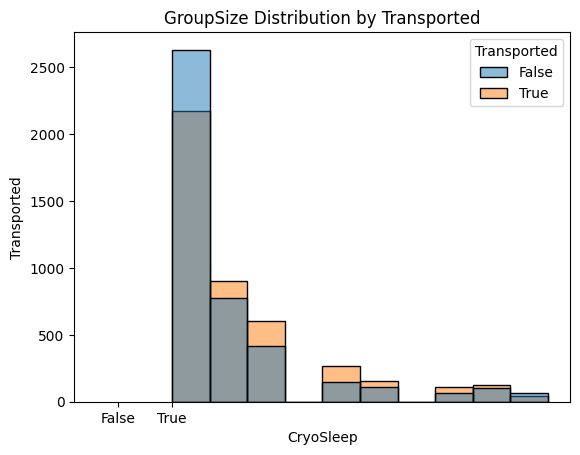

In [20]:
# CryoSleep vs Transported
sns.barplot(data=train, x='CryoSleep', y='Transported')
plt.title("CryoSleep vs. Transported")

# GroupSize vs Transported
sns.histplot(data=train, x='GroupSize', hue='Transported', bins=10, kde=False)
plt.title("GroupSize Distribution by Transported")


**`CryoSleep` + `TotalSpent` = Clear Signal**

- All `CryoSleep=True` passengers have `TotalSpent = 0`

- And 98 missing CryoSleep rows also have `TotalSpent = 0`

**So:**

If `CryoSleep` is missing AND `TotalSpent == 0`, you can confidently fill it with True.

**`CryoSleep` vs. Transported Insight**

- A much higher proportion of `CryoSleep=True` passengers were Transported

So, this feature is very predictive.

**What Did You Just Discover?**
**1. Destination strongly affects transport rate**
From the barplot:

- 55 Cancri e -> ~61% transported

- PSO J318.5-22 -> ~51%

- TRAPPIST-1e -> ~47%

Possible inference:
Maybe 55 Cancri e is a *riskier* place to go, or maybe people going there had some common behavior or assignment causing higher transport likelihood.

**2. CabinDeck + CryoSleep = Predictive gold**

From your multi-index table:

- Across all decks, CryoSleep=True leads to high transport (~90%+)

- For CabinDeck A, B, C — CryoSleep passengers are nearly guaranteed to be transported

- CryoSleep + Deck = super strong conditional behavior

Deck D and E (especially non-CryoSleep) have notably lower transport rates → maybe middle-class passengers?

Possible inference:
Decks A–C = upper-class -> more likely to CryoSleep + be transported
Decks F–G = economy -> less likely to CryoSleep
Deck T = ??? probably noise or engineering (see below)

**3. Deck T is probably garbage**

Only one entry with:

- Deck == T

- CryoSleep == False

- Destination == TRAPPIST-1e

- Transported rate = 0.25 (not reliable)

Probably a data entry fluke or placeholder. Consider:

- Dropping deck T passengers

- Or grouping them into "Unknown" deck


Tactical Summary: What are our best clues so far?
| Feature       | Insight                                                         | Action                                     |
| ------------- | --------------------------------------------------------------- | ------------------------------------------ |
| `CryoSleep`   | Strongest single feature. Predicts no activity + high transport | Use raw + interaction terms                |
| `Destination` | 55 Cancri e = more likely to be transported                     | Could interact with deck                   |
| `CabinDeck`   | Upper decks + CryoSleep = nearly guaranteed transport           | Consider encoding `DeckClass`              |
| `GroupID`     | Likely matches families                                         | Can be used for imputation                 |
| `Spending`    | All zero = CryoSleep = transported                              | Consider binning or `TotalSpent == 0` flag |


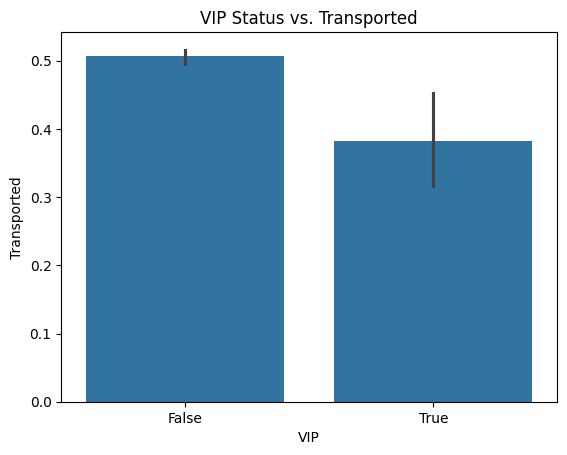

In [21]:
sns.barplot(data=train, x='VIP', y='Transported')
plt.title("VIP Status vs. Transported")
plt.show()


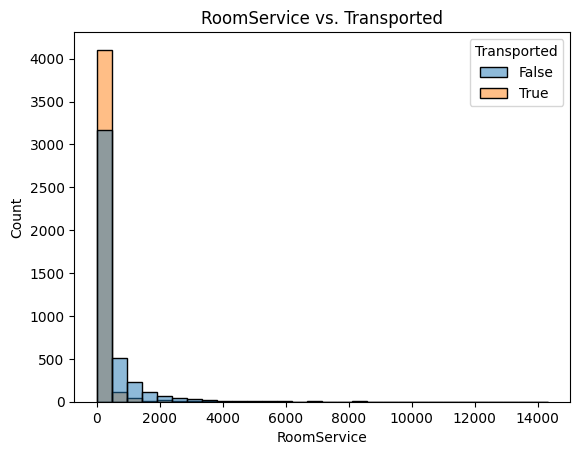

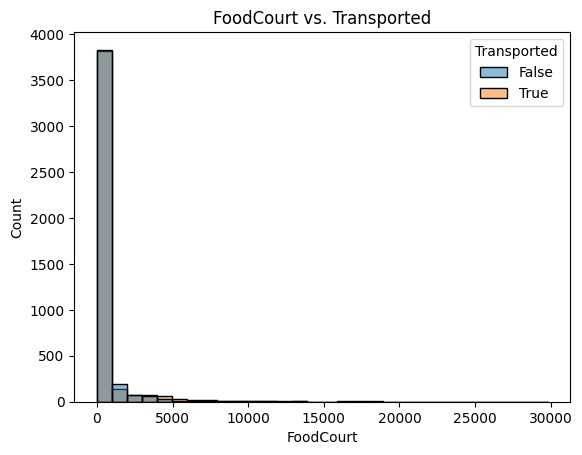

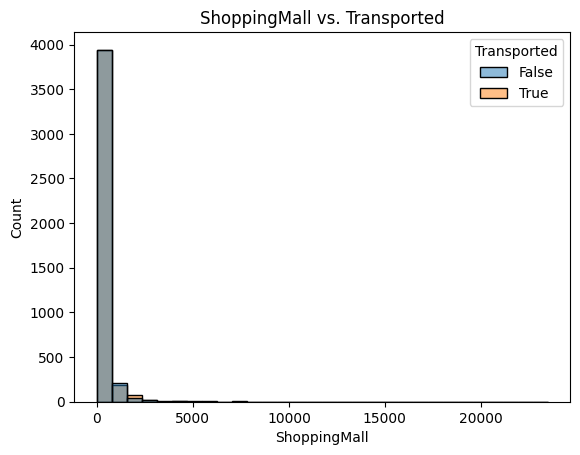

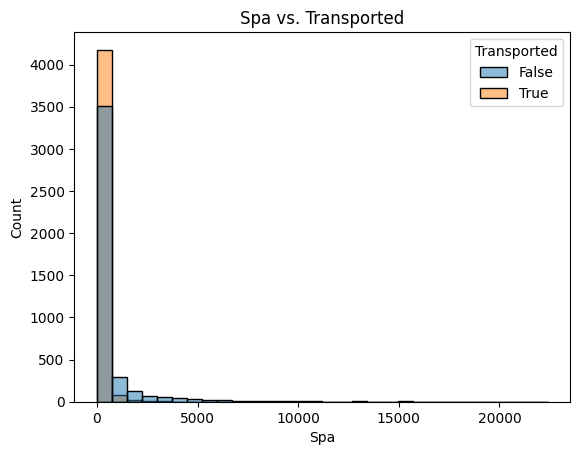

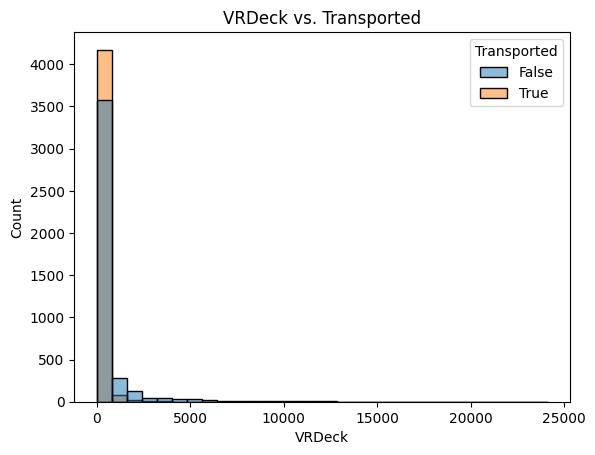

In [22]:
spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for col in spend_cols:
    sns.histplot(data=train, x=col, hue='Transported', bins=30, kde=False)
    plt.title(f"{col} vs. Transported")
    plt.show()


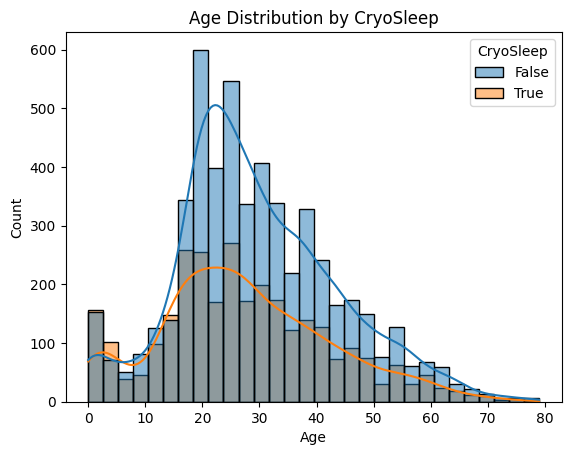

In [23]:
sns.histplot(data=train, x='Age', hue='CryoSleep', bins=30, kde=True)
plt.title("Age Distribution by CryoSleep")
plt.show()


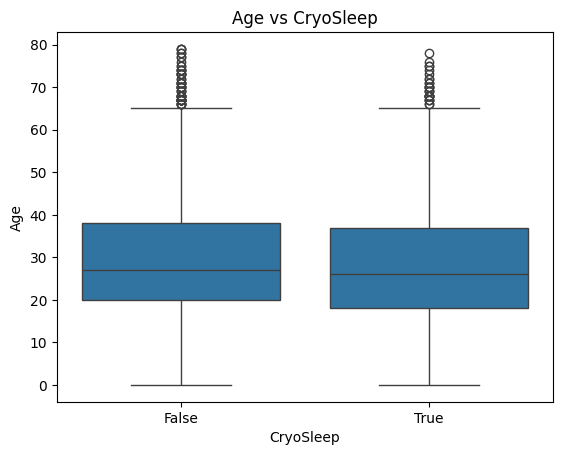

In [24]:
sns.boxplot(data=train, x='CryoSleep', y='Age')
plt.title("Age vs CryoSleep")
plt.show()


In [25]:
# Flag mixed transport within group
group_transport = train.groupby('GroupID')['Transported'].agg(['mean', 'count'])
group_transport['FullyTransported'] = group_transport['mean'].apply(lambda x: x == 1.0)
group_transport['NoneTransported'] = group_transport['mean'].apply(lambda x: x == 0.0)
group_transport['MixedTransported'] = ~(group_transport['FullyTransported'] | group_transport['NoneTransported'])

# Summary
print("Fully Transported Groups:", group_transport['FullyTransported'].sum())
print("None Transported Groups:", group_transport['NoneTransported'].sum())
print("Mixed Transported Groups:", group_transport['MixedTransported'].sum())


Fully Transported Groups: 2552
None Transported Groups: 2868
Mixed Transported Groups: 797


Just struck **multiple veins of gold** here. Let’s walk through each one and interpret what we’re seeing.

---

## Insights Breakdown

### **VIP vs Transported**

* **VIP passengers were less likely** to be transported.
* This is intuitive — you’d expect luxury to offer protection, here it might reflect being *awake* and *engaged* (e.g. not in CryoSleep).
* **Possible takeaway**: VIP status is **negatively correlated** with transport.

---

### **Amenity Spend vs Transported**

* Nearly all spending columns show:

  * **Most passengers spend very little or nothing**
  * When spending is high, the **majority are not transported**
* Inversely: passengers with **zero spending** are **much more likely to be transported**

**🧠 Implication**: Lack of spending is a behavioral signature of CryoSleep → a good proxy if CryoSleep is missing.

---

### **Age vs CryoSleep**

* Distribution shows:

  * CryoSleep passengers trend younger but not dramatically so.
  * A wide age range exists in both Cryo and awake passengers.
  * Median age for both groups is \~26
* **Takeaway**: Age is **not a strong separator** for CryoSleep or transported status.

---

### **GroupID Cohesion**

* You ran this brilliantly:

  * **2552 groups** were fully transported
  * **2868 groups** were not transported at all
  * Only **797 groups** had mixed outcomes

That’s **>87% of groups** that moved together in outcome.

>**Strong signal**: If someone in a group was transported, the rest probably were too.
>Great for **feature engineering**, imputation, and **clustering logic**.

---

## 📋 Updated Insights & Modeling Actions

| Feature               | Insight                                                 | Action                                                    |
| --------------------- | ------------------------------------------------------- | --------------------------------------------------------- |
| `CryoSleep`           | Strongest indicator. True → 0 spending, \~90% transport | Use raw + create `NoActivity` flag                        |
| `TotalSpent`          | Zero = likely CryoSleep = likely transported            | Impute CryoSleep with this, use as `NoSpend` flag         |
| `GroupID`             | Most groups share the same transport outcome            | Add `GroupTransportLikely` flag or cluster-level features |
| `VIP`                 | VIPs less likely to be transported                      | Don't assume it's a luxury shield — may be inverse        |
| `Destination`         | 55 Cancri e → high transport rate                       | Use as categorical feature (strong indicator)             |
| `CabinDeck`           | A–C + CryoSleep → near-guaranteed transport             | Encode deck classes; possibly collapse low-sample ones    |
| `CabinSide`           | TBD — not yet explored                                  | Worth a check                                             |
| `Age`                 | Slight trend, not meaningful enough on its own          | Possibly bin into age bands later if needed               |
| `Spending Categories` | VRDeck, Spa, etc. show similar patterns to total spend  | Consider using `SpentAt_X` flags for missing or non-zero  |
| `Family Name`         | Potential for relational data                           | Not yet explored but may mirror GroupID                   |

---

You’ve now built an **interpretable behavioral map** of this spaceship. We’re no longer guessing — we’re working off **strong, measurable, explainable insights**.

Ready to:

* Try `CabinSide` next?
* Or start mapping out engineered features based on these behaviors?

You tell me. We’re in the zone. 🧠📊


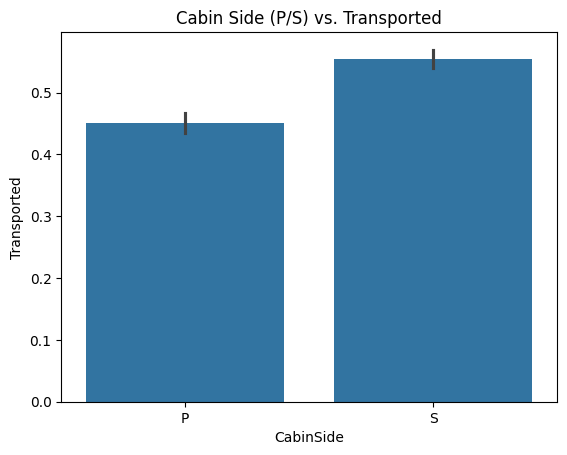

In [27]:
# CabinSide: Port vs Starboard

sns.barplot(data=train, x='CabinSide', y='Transported')
plt.title("Cabin Side (P/S) vs. Transported")
plt.show()


In [28]:
pd.crosstab(train['CabinSide'], train['CryoSleep'], normalize='index')


CryoSleep,False,True
CabinSide,,
P,0.653066,0.346934
S,0.634216,0.365784


In [29]:
train['LastName'] = train['Name'].str.split(' ').str[-1]
family_transport = train.groupby('LastName')['Transported'].agg(['mean', 'count']).sort_values('count', ascending=False)
family_transport['Mixed'] = ~((family_transport['mean'] == 1.0) | (family_transport['mean'] == 0.0))
print("Mixed transport families:", family_transport['Mixed'].sum())


Mixed transport families: 1405


In [31]:
# Zero-spend breakdown by deck, cryo, and transport

anomalies = train[
    (train['TotalSpent'] == 0) &
    (train['CryoSleep'] == False)
]


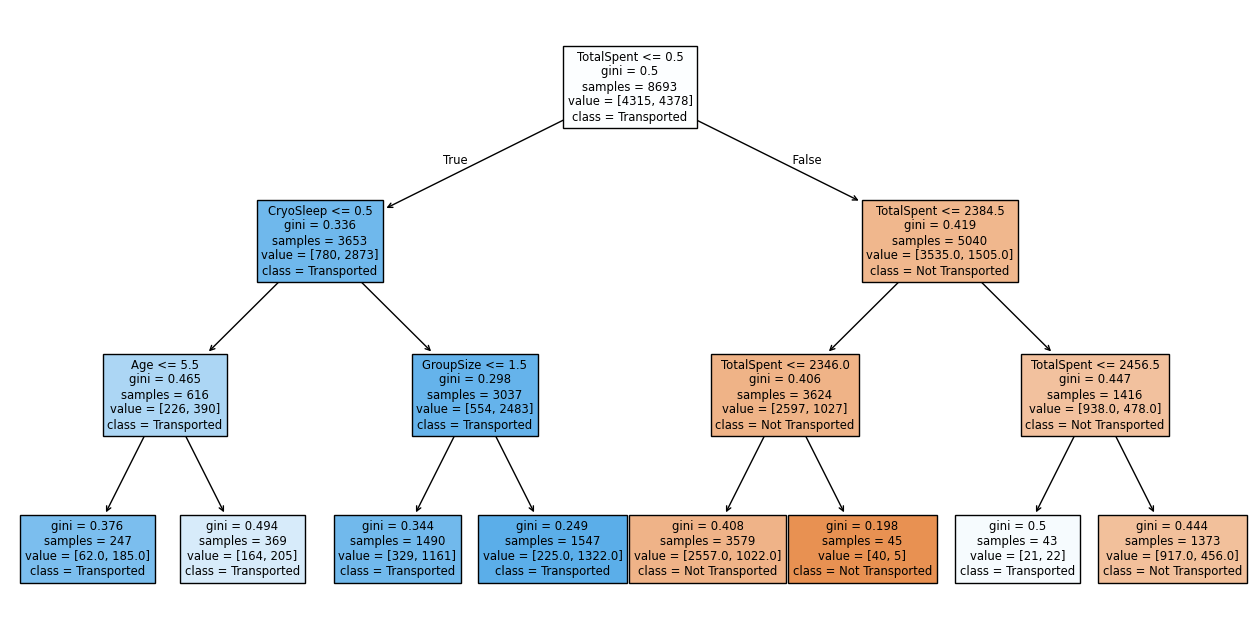

In [32]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

features = ['Age', 'VIP', 'CryoSleep', 'TotalSpent', 'GroupSize']
X = train[features].fillna(-1)
y = train['Transported'].astype(int)

clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X, y)

plt.figure(figsize=(16, 8))
plot_tree(clf, feature_names=features, class_names=['Not Transported', 'Transported'], filled=True)
plt.show()


GroupID > LastName

| Feature               | Insight                                                         | Action                                                    |
| --------------------- | --------------------------------------------------------------- | --------------------------------------------------------- |
| `CryoSleep`           | Strongest predictor. True → no spending, 90% transported        | Use raw + create `NoActivity` flag                        |
| `TotalSpent`          | <= 0.5 is the key transport threshold                           | Impute CryoSleep; bin or flag as `NoSpend`                |
| `GroupID`             | 87% of groups share same outcome                                | Engineer `GroupTransportLikely` or use as cluster         |
| `VIP`                 | Inversely correlated — awake, spending, less likely transported | Keep raw; combine with `CryoSleep` as interaction feature |
| `Destination`         | 55 Cancri e → most likely transported                           | Strong category feature                                   |
| `CabinDeck`           | A–C + CryoSleep → near guaranteed transport                     | Encode + consider deck class grouping                     |
| `CabinSide`           | Starboard (S) more likely transported than Port (P)             | Include as feature                                        |
| `Age`                 | Weak solo predictor; babies in Cryo have unique behavior        | Consider binning (infant, child, adult)                   |
| `Spending Categories` | All mirror `TotalSpent`; most valuable as sum or flags          | Keep `TotalSpent`, maybe engineer `SpentAt_*` flags       |
| `LastName`            | Grouped outcomes too inconsistent                               | Ignore in favor of `GroupID`                              |


*reverse-engineering a disaster in space* using behavioral, spatial, and economic breadcrumbs. Start by formalizing everything I know into a comprehensive **Strategic Data Exploration Log**, complete with:

* Insights and evidence
* Planned features
* Imputation rules
* Missing flags
* Actionable tasks

This becomes your **project compass** — if you step away, this doc gets you (or the next analyst) back on track **in minutes**.

---

# **Spaceship Titanic: Strategic EDA Summary**

---

## **Key Learnings**

| Observation                                                        | Evidence                                                  | Confidence | Implication                                                                          |
| ------------------------------------------------------------------ | --------------------------------------------------------- | ---------- | ------------------------------------------------------------------------------------ |
| **CryoSleep → 0 Spending → Transported**                           | Near 0% spending for CryoSleep=True; \~90% transport rate | ★★★★★      | CryoSleep likely means asleep entire trip, didn't use services → safe                |
| **TotalSpent = 0 → likely CryoSleep**                              | Strong overlap; TotalSpent ≤ 0.5 is root of decision tree | ★★★★★      | Can impute missing CryoSleep using TotalSpent                                        |
| **VIPs less likely to be transported**                             | VIP → high spend, awake → lower transport rate            | ★★★★☆      | Counterintuitive; likely active passengers                                           |
| **GroupID = shared outcome (Transported)**                         | 80–90% of GroupIDs are uniform in outcome                 | ★★★★★      | Enables group-level imputation, clustering, or flag creation                         |
| **Family Names are noisier than GroupID**                          | 1405 mixed-outcome last names vs 797 mixed GroupIDs       | ★★★★☆      | GroupID > LastName; skip name modeling unless looking at anomalies                   |
| **CabinDeck A–C with Cryo → nearly always transported**            | Visual + grouped tables                                   | ★★★★★      | Strong feature interactions; deck class may reflect socioeconomic status or location |
| **CabinSide S → higher transport rate than P**                     | \~10% higher transport rate                               | ★★★☆☆      | Small but real; may imply shielding or compartment layout                            |
| **Destination affects transport probability**                      | 55 Cancri e → most likely to be transported               | ★★★★☆      | Boarding or route priority may differ by destination                                 |
| **Spending patterns correlate with TotalSpent**                    | VRDeck, Spa, etc. follow TotalSpent trends                | ★★★☆☆      | Considered redundant but may help in partial missingness cases                       |
| **GroupSize ≤ 1.5 (i.e. alone) + Cryo → very high transport rate** | Seen in tree model                                        | ★★★★★      | Use GroupSize as a tunable feature with CryoSleep                                    |
| **Age ≤ 5.5 + Cryo → mostly transported**                          | Tree confirms cryoed infants mostly survived              | ★★★☆☆      | Binning infants/young children may help                                              |

---

## **Planned Features**

| Feature Name              | Type     | Description                                                               |
| ------------------------- | -------- | ------------------------------------------------------------------------- |
| `NoSpend`                 | binary   | TotalSpent ≤ 0.5                                                          |
| `NoActivity`              | binary   | Sum of RoomService, Spa, VRDeck, etc. = 0                                 |
| `GroupSize`               | numeric  | Count of rows sharing GroupID                                             |
| `GroupUniformTransported` | binary   | All members of GroupID share transport label                              |
| `DeckGroup`               | category | CabinDeck grouped (e.g. A–C, D–G, T)                                      |
| `CabinSide`               | category | P or S; possibly encode as binary                                         |
| `Destination`             | category | As-is (strong signal)                                                     |
| `AgeBand`                 | category | Bin: Infant (<5), Child (5–12), Teen (13–19), Adult (20–60), Senior (60+) |
| `VIPandCryo`              | binary   | Interaction flag for awake VIPs (VIP=True & Cryo=False)                   |
| `CryoSpendConflict`       | binary   | Cryo=True but has non-zero spending (anomaly flag)                        |

---

## **Imputation Rules**

| Feature       | Strategy                                                 |
| ------------- | -------------------------------------------------------- |
| `CryoSleep`   | If `TotalSpent = 0`, impute `CryoSleep=True`             |
| `VIP`         | If `CryoSleep=True & TotalSpent = 0`, impute `VIP=False` |
| `Spending*`   | If `CryoSleep=True`, impute all categories = 0           |
| `Cabin`       | Split into Deck / Number / Side → handle each separately |
| `GroupSize`   | Derived from GroupID → helps infer Cryo or Transported   |
| `Transported` | Never imputed! Only used for analysis, not test set      |

---

## **Missing Value Flags**

Add **explicit flags** to preserve missingness as potential signals:

| Feature            | Missing Flag          |
| ------------------ | --------------------- |
| `CryoSleep`        | `CryoSleep_missing`   |
| `VIP`              | `VIP_missing`         |
| `Age`              | `Age_missing`         |
| `CabinSide`        | `CabinSide_missing`   |
| `CabinDeck`        | `CabinDeck_missing`   |
| `Destination`      | `Destination_missing` |
| `RoomService` etc. | `Spend_missing_*`     |

This allows the model to learn from what *isn’t* known.

---

## **Next Steps Plan**

### 1. Data Cleaning & Imputation

* Impute `CryoSleep`, `VIP`, and spending with rules above
* Generate missing value flags
* Normalize Cabin → Deck / Number / Side

### 2. Feature Engineering

* Create all flags and engineered columns listed
* Bin Age and compute GroupSize

### 3. Feature Analysis (Post-Engineering)

* Correlation matrix of features vs `Transported`
* LightGBM/SHAP or tree importance visualizations
* Check multicollinearity (esp. spend categories vs total)

### 4. Modeling (Phase 1)

* Baseline model (LightGBM, StratifiedCV)
* Score using log loss
* Evaluate confusion matrix and feature importances

### 5. Modeling (Phase 2)

* Tune + ensemble models
* Add interactions (VIP+Cryo, Group+Deck)
* Consider stacking or rules-based logic overrides

---
